In [2]:
import torch
from tqdm import tqdm
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

## Data I/O convention

### Read
Shape of input_tensor.nhdr is `[w, h, 2]`, and Shape of input_mask.nhdr is `[w, h]`
```
input_tensor = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(2,1,0))
input_mask = np.transpose(sitk.GetArrayFromImage(sitk.ReadImage(path)),(1,0))
```
input_tensor.shape is `[2, h, w]`, and input_mask.shape is `[h, w]`
### Write
output_tensor.shape is `[2, h, w]`, and output_mask.shape is `[h, w]`
```
output_tensor = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
output_mask = sitk.WriteImage(sitk.GetImageFromArray(np.transpose(output_tensor,(2,1,0)), path)
```
Shape of output_tensor.nhdr is `[w, h, 2]`, and Shape of output_mask.nhdr is `[w, h]`

### Note
`sitk.WriteImage(sitk.GetImageFromArray())` and `sitk.GetArrayFromImage(sitk.ReadImage(path))` is a pair of inverse operation, and you can see there is no inconsistence with regards to the dimension issue.
```
output_tensor = np.zeros((12,34,56,78))
sitk.WriteImage(sitk.GetImageFromArray(output_tensor), path)
input_tensor = sitk.GetArrayFromImage(sitk.ReadImage(path))
print(input_tensor)
'(12,34,56,78)'
```

## Data dim convention

Make sure you follow the conventions below to make the algorithm consistent.
- Tensor fields: All the tensor fields variables by default are of size `[h, w, 2, 2]`, making the last two dimensions index metric matrix, to comply pytorch. In my code, arguments and the outputs of all functions meet this requirement. 
- Diffeomorphisms: All the diffeo variables by default are of size `[2, h, w]`.
- Masks: All the mask variables by default are of size `[h, w]`, when it comes to `torch.einsum()`, you can use `.unsqueeze(0)` for temporary.

## Data plotting convention

To avoid the `x` and `y` ambiguity in indexing and ploting, naming the first two dimension in `[h, w, 2, 2]` in the order of `x`, `y` is the best choice! 
- When indexing the array, `x` indexes row and `y` indexes column, the way I typically do and the way how matplotlib plot the 2d image. 
- When plotting the tensors, matplotlib would rotate the array counterclockwise by 90 degrees. So the vertical axis is `y` and horizontal axis is `x`, which is also consistent with our knowledge in drawing the Cartesian coordinate system. Fortunately, Kirs' code has already done in this way, like the ellipse(x, y). 


## Algorithm caveat
- In energy calculation, only use the binary mask provided by Kris, rather than a weighted map, which will change the alpha field applied to the tensor field previously and result in geodesic misgoing.
- Both metric matching and mean calculating should be implemented on the inverse of the original DTI tensor field, since the geodesics are running on the inverse of the tensor field.
- When accumulating the diffeomorphisms, always remember the order of accumulation of phi and its inverse is different.
```
phi_acc = compose_function(phi_acc, phi)
psi_inv_acc = compose_function(phi_inv, psi_inv_acc)
```
- When an error like below is raised, it's probably caused by a large epsilon, so the composed tensor field is no longer positive definite everywhere.
```
cholesky_cpu: For batch 0: U(1,1) is zero, singular U.
```
- `a` in `Squared_distance_Ebin(g0, g1, a, mask)`, `get_karcher_mean(G, a)`, `get_geo(g0, g1, a, Tpts)`, `inv_RieExp_extended(g0, g1, a)`, `Rie_Exp_extended(g0, u, a)`, `Rie_Exp(g0, u, a)`, `inv_RieExp(g0, g1, a)` equals to the reciprocal of dimension, `1/dim`, namely the last entry of tensor field's shape.

In [3]:
def phi_pullback(phi, g):
#     input: phi.shape = [2, h, w]; g.shape = [h, w, 2, 2]
#     output: shape = [h, w, 2, 2]
    g = g.permute(2,3,0,1)
    idty = get_idty(*g.shape[-2:])
    d_phi = get_jacobian_matrix(phi - idty) + torch.einsum("ij,mn->ijmn", [torch.eye(2,dtype=torch.double),
                                                                           torch.ones(g.shape[-2:],dtype=torch.double)])
    g_phi = compose_function(g, phi)
    return torch.einsum("ijmn,ikmn,klmn->mnjl",[d_phi, g_phi, d_phi])


def energy_ebin(phi, g0, g1, f0, f1, sigma, lambd, mask): 
#     input: phi.shape = [2, h, w]; g0/g1/f0/f1.shape = [h, w, 2, 2]; sigma/lambd = scalar; mask.shape = [1, h, w]
#     output: scalar
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    E1 = sigma*Squared_distance_Ebin(f0, phi_star_f1, lambd, mask)
    E2 = Squared_distance_Ebin(g0, phi_star_g1, lambd, mask)
    return E1 + E2


def energy_L2(phi, g0, g1, f0, f1, sigma, mask): 
#     input: phi.shape = [2, h, w]; g0/g1/f0/f1.shape = [h, w, 2, 2]; sigma/lambd = scalar; mask.shape = [1, h, w]
#     output: scalar
    phi_star_g1 = phi_pullback(phi, g1)
    phi_star_f1 = phi_pullback(phi, f1)
    E1 = sigma*torch.einsum("ij...,kij->", (f0 - phi_star_f1)**2, mask.unsqueeze(0))
    E2 = torch.einsum("ij...,kij->", (g0 - phi_star_g1)**2, mask.unsqueeze(0))
    return E1 + E2


def laplace_inverse(u):
#     input: u.shape = [2, h, w]
#     output: shape = [2, h, w]
    size_h, size_w = u.shape[-2:]
    shape = u.shape
    idty = get_idty(size_h, size_w).numpy()
    lap = 4. - 2.*(np.cos(2.*np.pi*idty[0]/size_w) + np.cos(2.*np.pi*idty[1]/size_h))
    lap[0,0] = 1.
    lapinv = 1./lap
    lap[0,0] = 0.
    lapinv[0,0] = 1.
    
    u = u.detach().numpy()
    fx = np.fft.fftn(u[0])
    fy = np.fft.fftn(u[1])
    fx *= lapinv
    fy *= lapinv
    vx = torch.from_numpy(np.real(np.fft.ifftn(fx)))
    vy = torch.from_numpy(np.real(np.fft.ifftn(fy)))
    
    return torch.stack((vx,vy))


def vis_squared_distance_ebin(g0, g1, a):  
    inv_g0 = get_inverse(g0)
    inv_g0_g1 = torch.einsum("ik...,kj...->...ij",[inv_g0, g1]) 
    trK0square = trKsquare(g0, g1) - torch.log(get_det(inv_g0_g1) + 1e-25)**2/2 
    theta = torch.min((trK0square/a + 1e-25).sqrt()/4, torch.tensor([np.pi],dtype=torch.double))
    
    det_g0 = g0[0, 0] * g0[1, 1] - g0[0, 1] * g0[1, 0] + 1e-25
    det_g1 = g1[0, 0] * g1[1, 1] - g1[0, 1] * g1[1, 0] + 1e-25
    
    alpha, beta = det_g0.pow(1/4), det_g1.pow(1/4)
    E = 16*a*(alpha**2 - 2*alpha*beta*torch.cos(theta) + beta**2)
    fig = plt.figure()
    im = plt.imshow(E)
    fig.colorbar(im)
    plt.gca().invert_yaxis()
    plt.show()
    return 0


def GetSITKImageFromNP(npimg, has_component_data=False):
  # If RGB or tensor data etc, set has_component_data to True so that last dimension is not
  # transposed.
  # This assumes that the component data is in the last dimension.
  # TODO fix this assumption to work for component data in first dimension as well
  # Currently works for 2D and 3D images
  if has_component_data:
    transpose_tuple=(1,0,2)
    if len(npimg.shape) == 4:
      transpose_tuple=(2,1,0,3)    
    return sitk.GetImageFromArray(np.transpose(npimg,transpose_tuple))
  else:
    transpose_tuple=(1,0)
    if len(npimg.shape) == 3:
      transpose_tuple=(2,1,0)           
    return sitk.GetImageFromArray(np.transpose(npimg, transpose_tuple))

        
def metric_matching(gi, gm, height, width, mask, iter_num, epsilon, sigma):
    phi_inv = get_idty(height, width)
    phi = get_idty(height, width)
    idty = get_idty(height, width)
    idty.requires_grad_()
    f0 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1)
    f1 = torch.eye(2, dtype=torch.double).repeat(height, width,1,1)
    
    for j in range(iter_num):
        phi_actsg0 = phi_pullback(phi_inv, gi)
        phi_actsf0 = phi_pullback(phi_inv, f0)
        E = energy_ebin(idty, phi_actsg0, gm, phi_actsf0, f1, sigma,0.5, mask) 
        E.backward()
        v = - laplace_inverse(idty.grad)
        with torch.no_grad():
            psi =  idty + epsilon*v  
            psi[0][psi[0]>width-1]=width-1
            psi[1][psi[1]>height-1]=height-1
            psi[psi<0]=0
            psi_inv =  idty - epsilon*v
            psi_inv[0][psi_inv[0]>width-1]=width-1
            psi_inv[1][psi_inv[1]>height-1]=height-1
            psi_inv[psi_inv<0]=0
            phi = compose_function(psi, phi)
            phi_inv = compose_function(phi_inv, psi_inv)
            idty.grad.data.zero_()
    gi = phi_pullback(phi_inv, gi)
    return gi, phi, phi_inv

## Main Process

In [4]:
file_name = [1,2,4,6]
height, width = 100,100
sample_num = len(file_name)
input_dir = 'Data/Cubic'
output_dir = 'Output/Cubic1246Atlas'
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
tensor_lin_list, tensor_met_list, mask_list, mask_thresh_list = [], [], [], []
mask_union = torch.zeros(height, width).double()
phi_inv_acc_list, phi_acc_list, energy_list = [], [], []

for s in range(len(file_name)):
#     read tensor and mask files
    tensor_np = sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{file_name[s]}_scaled_tensors.nhdr'))
    mask_np = sitk.GetArrayFromImage(sitk.ReadImage(f'{input_dir}/cubic{file_name[s]}_filt_mask.nhdr'))
    tensor_lin_list.append(torch.from_numpy(tensor_np).double().permute(2,1,0))
#     create union of masks
    mask_union += torch.from_numpy(mask_np).double().permute(1,0)
    mask_list.append(torch.from_numpy(mask_np).double().permute(1,0))
#     rearrange tensor_lin to tensor_met
    tensor_met_zeros = torch.zeros(height,width,2,2,dtype=torch.double)
    tensor_met_zeros[:,:,0,0] = tensor_lin_list[s][0]
    tensor_met_zeros[:,:,0,1] = tensor_lin_list[s][1]
    tensor_met_zeros[:,:,1,0] = tensor_lin_list[s][1]
    tensor_met_zeros[:,:,1,1] = tensor_lin_list[s][2]
#     balance the background and subject by rescaling
    tensor_met_list.append(torch.inverse(tensor_met_zeros))
    mask_thresh_list.append(torch.where(torch.det(tensor_met_list[s])>1e7, 1/torch.det(tensor_met_list[s]), 5e-3))
    tensor_met_list[s] = torch.einsum('ij...,kij->ij...', tensor_met_list[s], mask_thresh_list[s].unsqueeze(0))
#     initialize the accumulative diffeomorphism
    phi_inv_acc_list.append(get_idty(height, width))
    phi_acc_list.append(get_idty(height, width))
    energy_list.append([])    
    
mask_union[mask_union>0] = 1

In [5]:
for i in tqdm(range(101)):
    G = torch.stack(tuple(tensor_met_list))
    a = 0.5
    atlas = get_karcher_mean(G, a)

    lambd, sigma, epsilon, iter_num = 0.5, 0, 5e0, 1
    phi_inv_list, phi_list = [], []
    for s in range(sample_num):
        energy_list[s].append(torch.einsum("ij...,kij->",[(tensor_met_list[s] - atlas)**2, mask_union.unsqueeze(0)]).item())
        tensor_met_list[s], phi, phi_inv = metric_matching(tensor_met_list[s], atlas, height, width, mask_union, iter_num, epsilon, sigma)
        phi_inv_list.append(phi_inv)
        phi_list.append(phi)
        phi_inv_acc_list[s] = compose_function(phi_inv_acc_list[s], phi_inv_list[s])
        phi_acc_list[s] = compose_function(phi_list[s], phi_acc_list[s])
        mask_list[s] = compose_function(mask_list[s], phi_inv_list[s])
        
    if i%5==0:
        atlas_lin = np.zeros((3,height,width))
        mask_acc = np.zeros((height,width))
        atlas_inv = torch.inverse(atlas)
        atlas_lin[0] = atlas_inv[:,:,0,0].cpu()
        atlas_lin[1] = atlas_inv[:,:,0,1].cpu()
        atlas_lin[2] = atlas_inv[:,:,1,1].cpu()
        for s in range(sample_num):
            sio.savemat(f'{output_dir}/cubic{file_name[s]}_{i}_phi_inv.mat', {'diffeo': phi_inv_acc_list[s].cpu().detach().numpy()})
            sio.savemat(f'{output_dir}/cubic{file_name[s]}_{i}_phi.mat', {'diffeo': phi_acc_list[s].cpu().detach().numpy()})
            sio.savemat(f'{output_dir}/cubic{file_name[s]}_{i}_energy.mat', {'energy': energy_list[s]})
#             plt.plot(energy_list[s])
            mask_acc += mask_list[s].cpu().numpy()
        mask_acc[mask_acc>0]=1
        sitk.WriteImage(sitk.GetImageFromArray(np.transpose(atlas_lin,(2,1,0))), f'{output_dir}/atlas_{i}_tens.nhdr')
        sitk.WriteImage(sitk.GetImageFromArray(np.transpose(mask_acc,(1,0))), f'{output_dir}/atlas_{i}_mask.nhdr')

  0%|          | 0/101 [00:00<?, ?it/s]/home/sci/hdai/Projects/Atlas2D/Packages/SplitEbinMetric.py:270: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  Ind_inRange = (theta < 0).nonzero().reshape(-1)  ## G[i] is in the range of the exponential map at gm
100%|██████████| 101/101 [01:22<00:00,  1.22it/s]


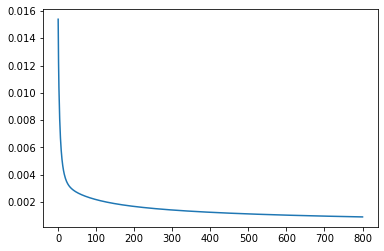

In [20]:
plt.figure()
plt.plot(energy_list[1])

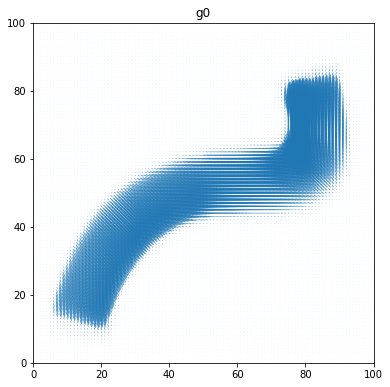

In [15]:
show_2d_tensors(atlas, scale=1e3, title="g0", margin=0.05, dpi=20)

# tl = torch.from_numpy(sitk.GetArrayFromImage(sitk.ReadImage('orig_result.nhdr'))).double().permute(2,1,0)
# tm = torch.zeros(height,width,2,2,dtype=torch.double)
# tm[:,:,0,0] = tl[0]
# tm[:,:,0,1] = tl[1]
# tm[:,:,1,0] = tl[1]
# tm[:,:,1,1] = tl[2]

# print(torch.norm((tm-atlas)/atlas))

## Save Result

In [ ]:
# atlas_lin = np.zeros((3,height,width))
# mask_acc = np.zeros((height,width))

# for s in range(sample_num):
#     sio.savemat(f'{output_dir}/cubic{file_name[s]}_phi_inv.mat', {'diffeo': phi_inv_acc_list[s].detach().numpy()})
#     sio.savemat(f'{output_dir}/cubic{file_name[s]}_phi.mat', {'diffeo': phi_acc_list[s].detach().numpy()})
#     sio.savemat(f'{output_dir}/cubic{file_name[s]}_energy.mat', {'energy': energy_list[s]})
#     plt.plot(energy_list[s])
#     mask_acc += mask_list[s].numpy()
    
# atlas_lin[0]=atlas[:,:,0,0]
# atlas_lin[1]=atlas[:,:,0,1]
# atlas_lin[2]=atlas[:,:,1,1]
# sitk.WriteImage(sitk.GetImageFromArray(np.transpose(atlas_lin,(2,1,0))), '{output_dir}/atlas_tensors.nhdr')
# sio.savemat('{output_dir}/mask_acc.mat', {'mask': mask_acc})

In [ ]:
# j = 1
# idty = compose_function(phi_inv_acc_list[j], phi_acc_list[j])
# plot_diffeo(idty, step_size=2, show_axis=True)